In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from scipy.interpolate import interp1d
from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')


np.random.seed(22)

import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

## Helper Functions

In [2]:
def create_nans_continously(data,perc=0.1):
    arr=data.copy()
    arr=arr.astype('float')
    loc=np.random.choice(np.arange(0,len(data)*(1-perc)-1),size=1)[0]
    arr[int(loc):int(loc)+int(len(data)*perc)] = -999
    arr[arr == -999] = np.nan
    return arr


def create_nans_random(data,perc=0.1):
    missing_len=int(len(data)*perc)
    arr=data.copy()
    arr=arr.astype('float')
    for _ in range(missing_len):
            ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            arr[ind]=np.nan    
    return arr


def create_nans_selectively(data,perc=0.1):
    arr=data.copy()
    missing_len=int(len(arr)*perc)
    # Consecutively
    for i in range(3):
        temp_miss=int(np.random.choice(np.arange(0.1*missing_len/3,missing_len/3),size=1)[0])
        loc_st=int(np.random.choice(np.arange(len(data)*i//3,len(data)*(i+1)//3-temp_miss),size=1)[0])
        k=0
        while temp_miss!=k and loc_st<len(data):
            if not pd.isnull(arr[loc_st]):
                arr[loc_st]=np.nan
                k+=1
            loc_st+=1
        missing_len-=k
        # Randomly
    for _ in range(missing_len):
            ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            arr[ind]=np.nan    
    return arr

In [3]:
def find_num(P,threshold):
    n=threshold*P[0]
    for i,val in enumerate(P):
        if val<n:
            return i
    return i+1

def find_missing_blocks(input_list):
    missing_blocks_len = []
    current_block = []

    for item in input_list:
        if pd.isnull(item):  # You can change this condition to match the type of missing value in your list
            current_block.append(item)
        elif current_block:
            missing_blocks_len.append(len(current_block))
            current_block = []

    if current_block:
        missing_blocks_len.append(len(current_block))
    missing_blocks_len.sort(reverse=True)

    if len(missing_blocks_len)==0:
        missing_blocks_len=[0]
    return missing_blocks_len


def score(P,l,t):
    """
    P: Array containing contiguous NaN's in descending order
    l : Length of array
    """
    n=find_num(P,t)
    e1= (1-sum(P)/l)
    #e2= np.exp((1-np.mean(P[:n])/l)**3)/np.exp(1)
    if n==0:
        e2=1
        #warnings.simplefilter("default")
        #warnings.warn("Looks like Threshold>1, So Score returned is just nan %")  
    else:
        e2= (1-np.mean(P[:n])/l)
    return round(e1*e2,4)

def find_score(data,threshold):
    arr_missing=find_missing_blocks(data)
    return score(arr_missing,len(data),threshold)


def rmse_data(true,pred):
    return np.sqrt(1/len(true)*np.sum(np.square((true-pred))))

In [4]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def knn_interpolate(data):
    arr=data.copy()
    time=np.arange(1,len(arr)+1,1)
    df=pd.DataFrame({'time':time,'arr':arr})
    knn=KNNImputer(n_neighbors=10)
    imputed=pd.DataFrame(knn.fit_transform(np.array(df)),columns=df.columns)['arr'].values
    return imputed

def spline_interpolation(arr, degree):
    x=arr.copy()
    nan_indices = np.isnan(x)
    non_nan_indices = np.arange(len(x))[~nan_indices]
    non_nan_values = arr[~nan_indices]

    if degree==1:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='slinear', fill_value='extrapolate')
    elif degree==2:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='quadratic', fill_value='extrapolate')
    elif degree==3:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    interpolated_values = interpolator(np.arange(len(x)))

    return interpolated_values

## Pre Process Data

In [10]:
path_data="D:\\BTP\\Data\\trends_synthetic_case"
df=pd.read_csv(f'{path_data}/Data_50_series_k4.csv')
df=df.sample(frac=1).reset_index(drop=True)
all_labels=df['labels'].values
all_data=df.drop('labels',axis=1)
df.head()

0          1          2          3          4          5  \
0  39.810256  42.178466  36.141791  38.295683  35.115999  40.220214   
1  31.547145  35.437232  34.678442  30.120320  32.604023  34.855714   
2  34.671483  30.209427  33.573132  29.326534  30.372674  30.139603   
3  35.691038  39.357387  37.716203  36.095712  38.120323  37.564336   
4  49.799778  52.847181  51.680468  51.478041  50.167163  50.826934   

           6          7          8          9  ...        721        722  \
0  34.404667  42.352747  38.945213  38.748182  ...  31.140620  34.241034   
1  40.602578  32.237623  38.153391  33.836727  ...  42.525579  40.606546   
2  31.345561  34.627868  33.987022  32.073236  ...  36.904387  41.082950   
3  35.325546  33.603264  34.467263  38.806934  ...  31.705422  30.073986   
4  54.553488  54.046172  52.507087  56.056636  ...  27.789958  29.271819   

         723        724        725        726        727        728  \
0  30.465124  32.928591  39.001469  34.818518  31.091512  31.826378   
1  39.609465  41.002066  39.828128  42.845817  42.344790  42.826494   
2  42.547137  41.237268  42.000586  40.249721  41.183557  41.523058   
3  32.687988  34.456245  25.230281  30.539512  31.867246  32.880450   
4  30.504728  32.025775  31.125130  32.160008  29.367307  31.640865   

         729  labels  
0  34.678272     0.0  
1  41.653940     3.0  
2  38.476877     3.0  
3  31.958107     0.0  
4  24.397905     1.0  

[5 rows x 731 columns]

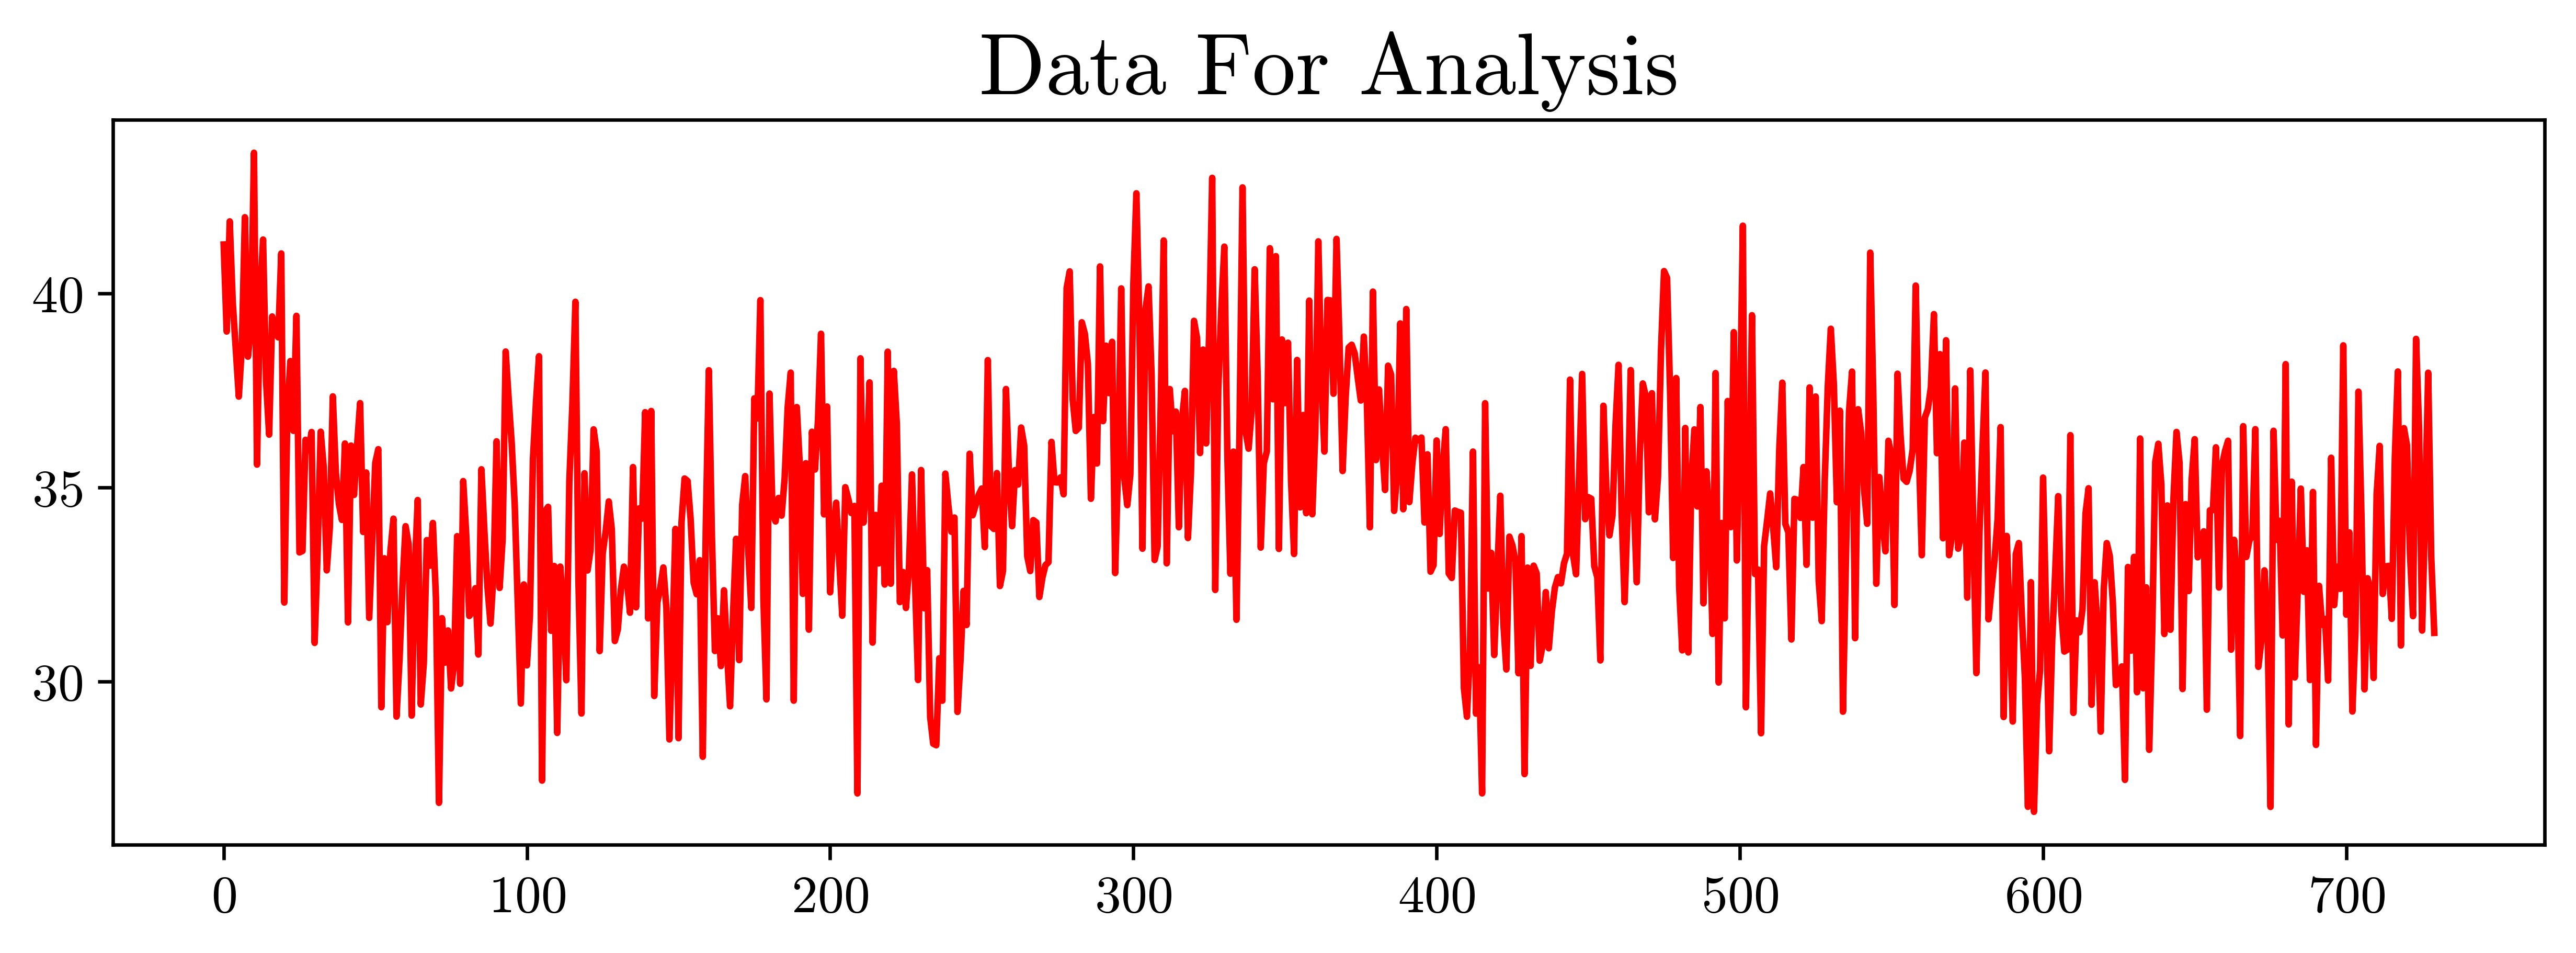

In [11]:
data=np.array(all_data)[7]
plt.figure(figsize=(10,3))
plt.title('Data For Analysis')
plt.plot(data,'r-')
plt.show()

RMSE for Interpolation: 2.15


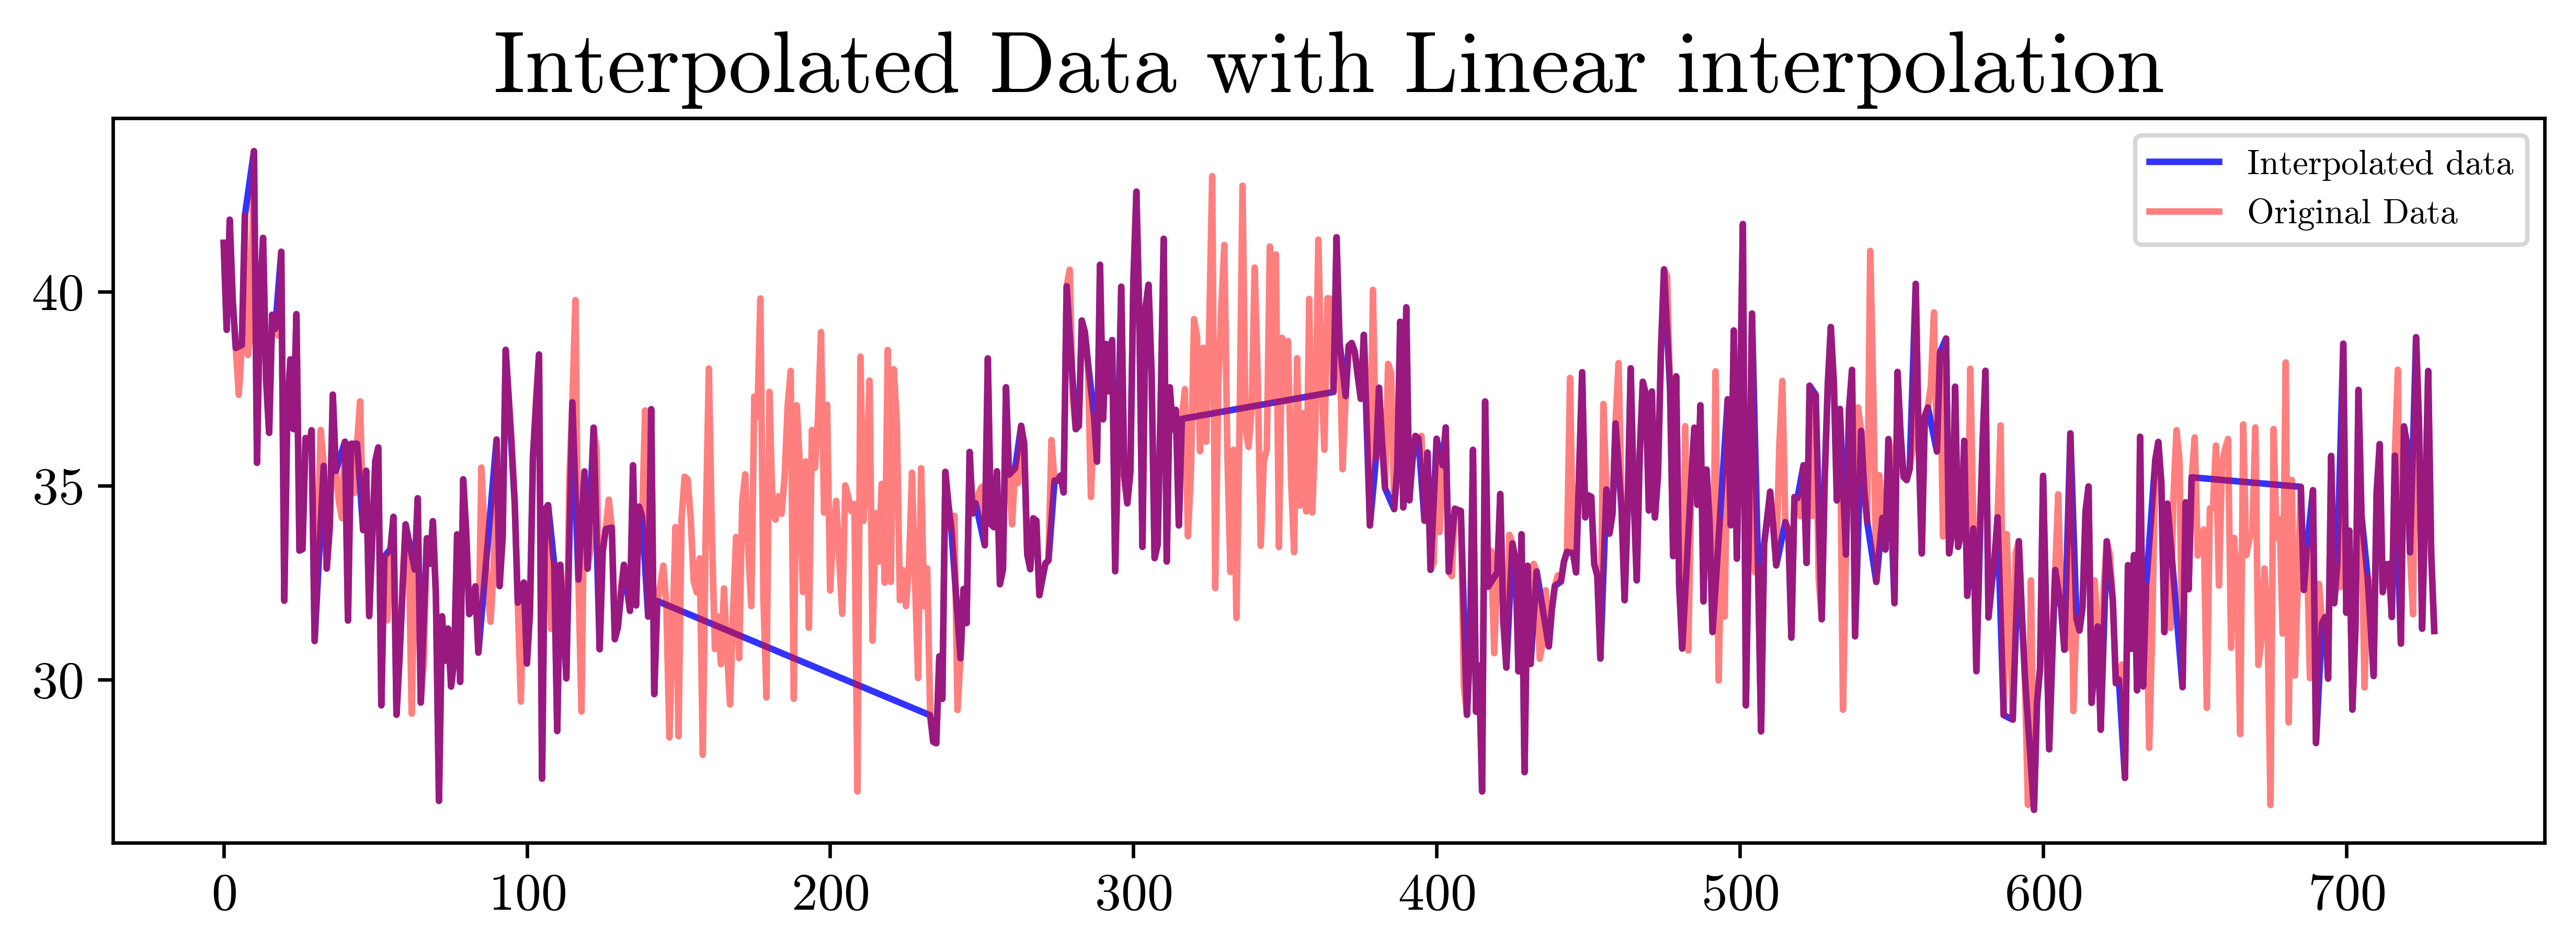

In [12]:
missing_data=create_nans_selectively(data,perc=0.4)
plt.figure(figsize=(10,3))
plt.title('Interpolated Data with Linear interpolation')
#plt.plot(missing_data,'g--',linewidth=1.5)
data_int=linear_int(missing_data)
plt.plot(data_int,'b-',alpha=0.8,label='Interpolated data')
print(f'RMSE for Interpolation: {rmse_data(data_int,data):.2f}')
plt.plot(data,'r-',alpha=0.5,label='Original Data')
plt.legend()
plt.show()

RMSE for Interpolation: 1.64


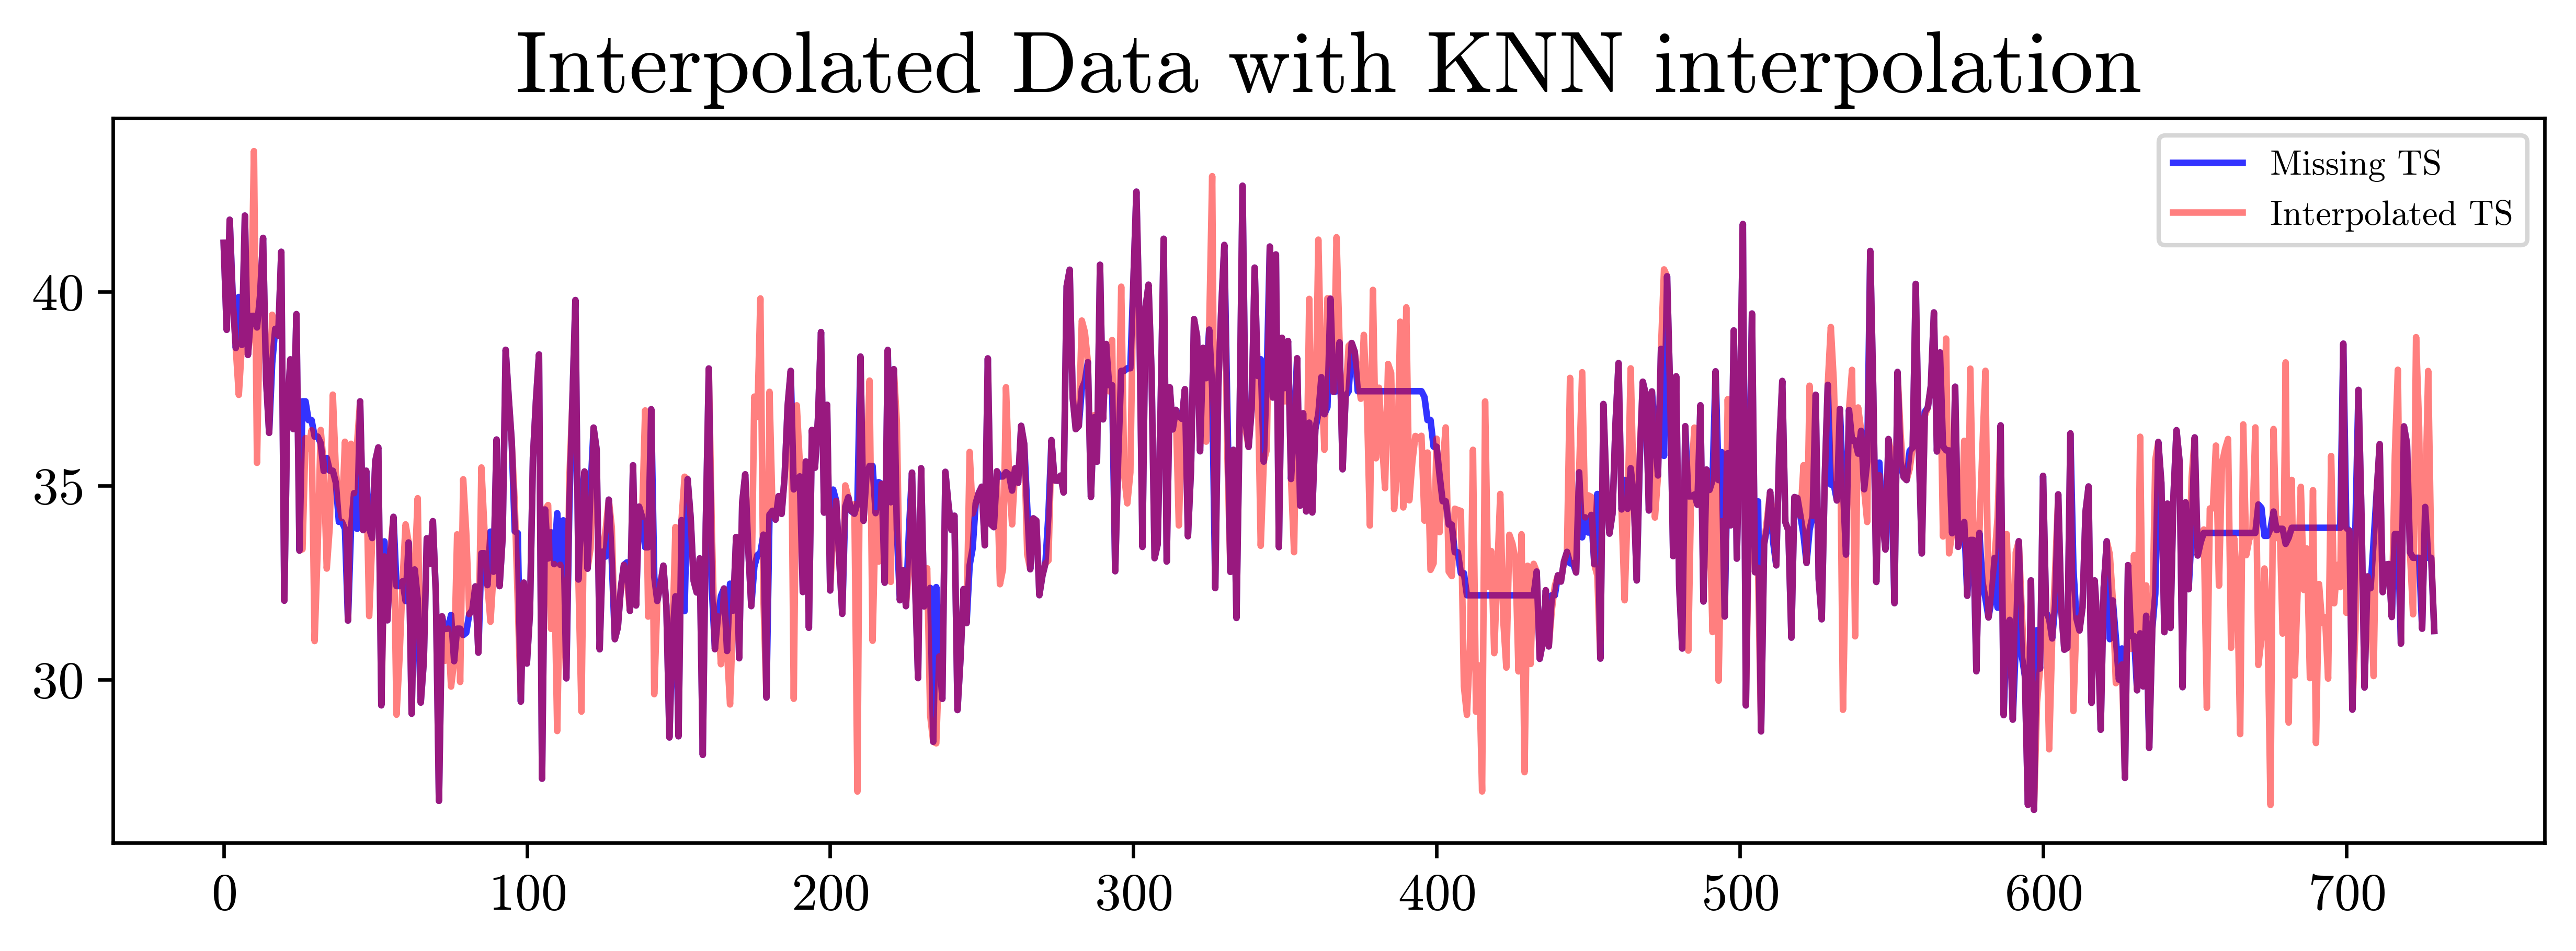

In [13]:
missing_data=create_nans_selectively(data,perc=0.4)
plt.figure(figsize=(10,3))
plt.title('Interpolated Data with KNN interpolation')
#plt.plot(missing_data,'g--',linewidth=1.5)
data_int=knn_interpolate(missing_data)
plt.plot(data_int,'b-',alpha=0.8)
print(f'RMSE for Interpolation: {rmse_data(data_int,data):.2f}')
plt.plot(data,'r-',alpha=0.5)
plt.legend(['Missing TS','Interpolated TS','Original Data'])
plt.show()

RMSE for Interpolation: 5.73


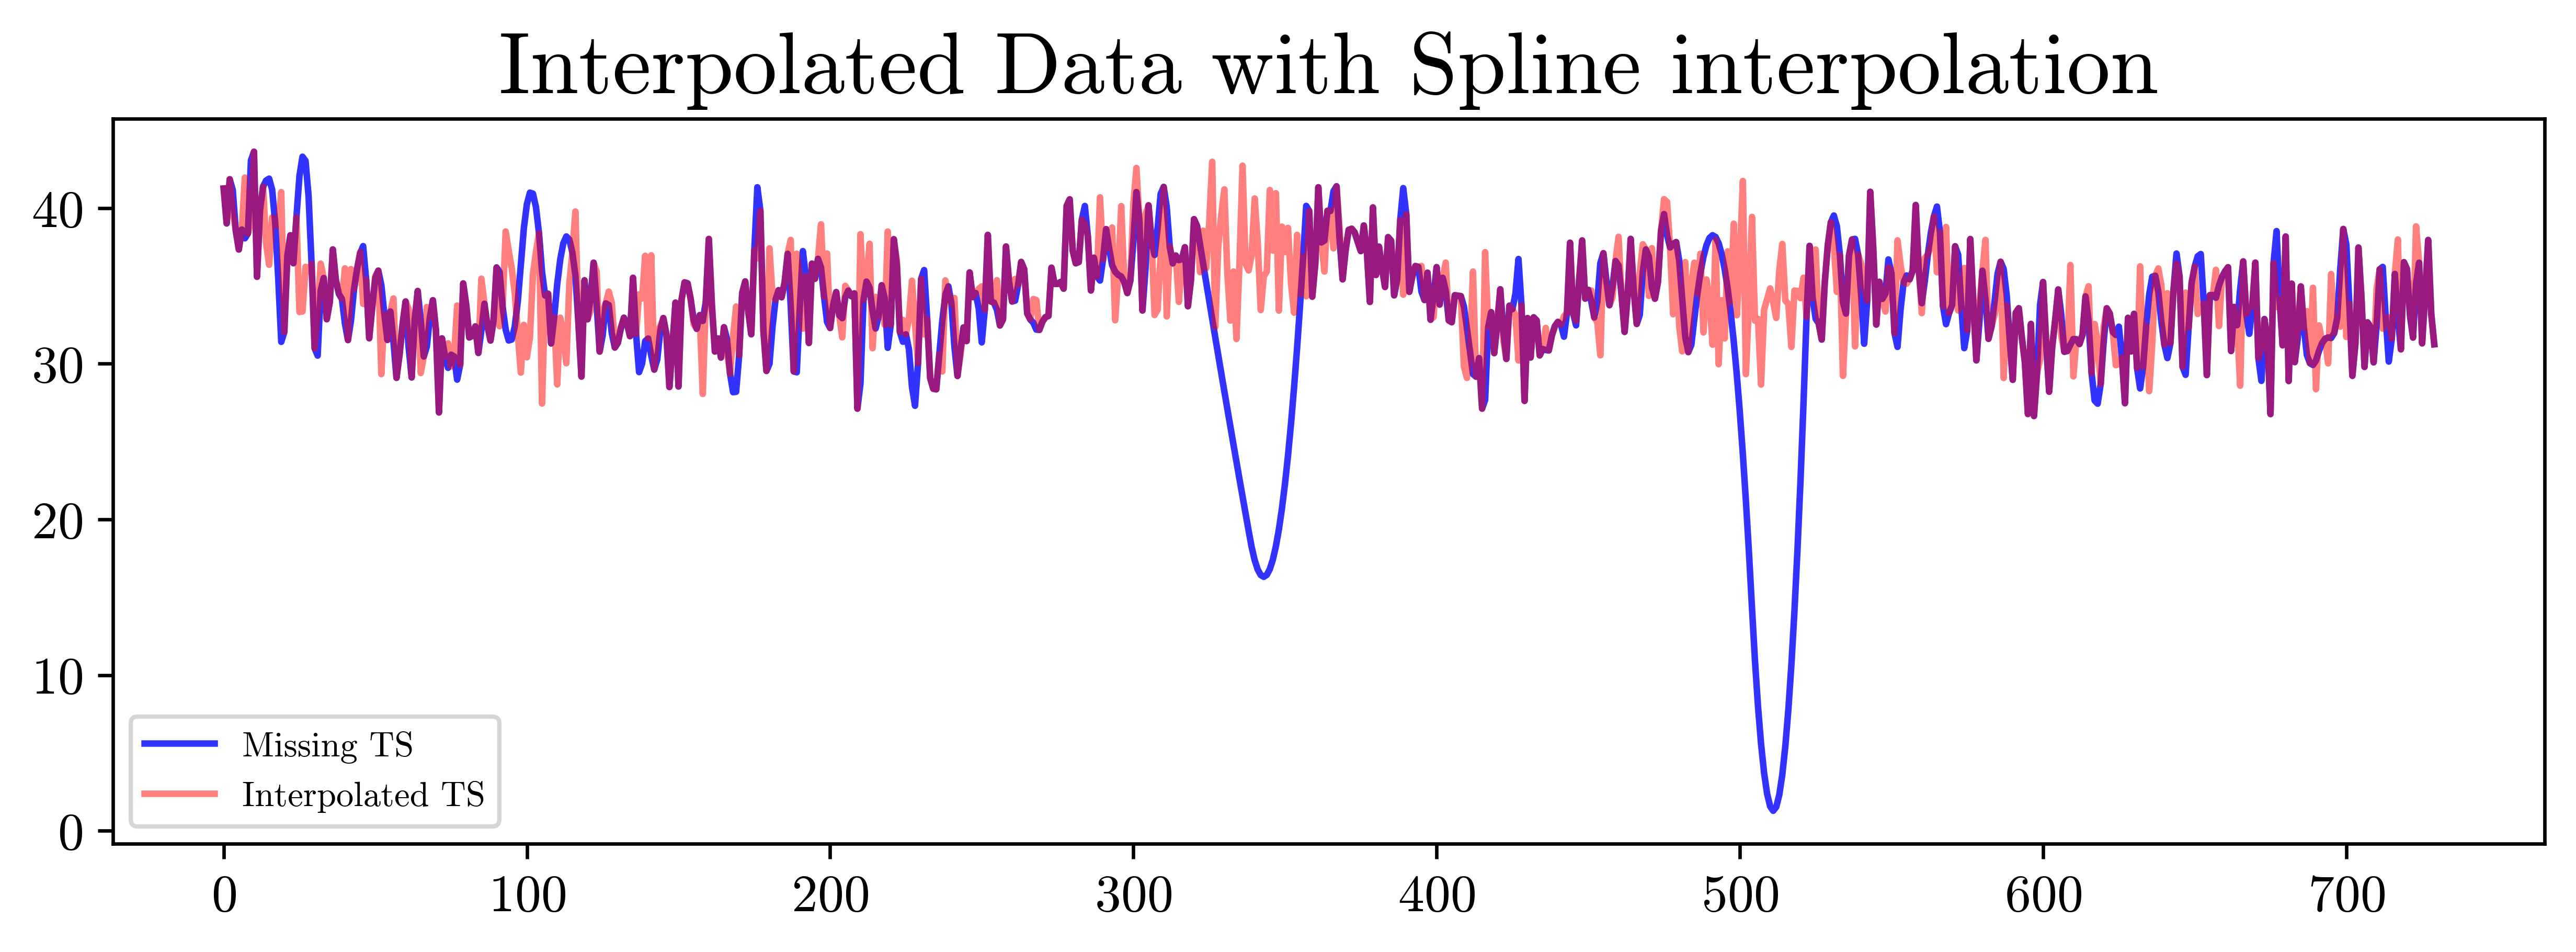

In [14]:
missing_data=create_nans_selectively(data,perc=0.4)
plt.figure(figsize=(10,3))
plt.title('Interpolated Data with Spline interpolation')
#plt.plot(missing_data,'g--',linewidth=1.5)
data_int=spline_interpolation(missing_data,2)
plt.plot(data_int,'b-',alpha=0.8)
print(f'RMSE for Interpolation: {rmse_data(data_int,data):.2f}')
plt.plot(data,'r-',alpha=0.5)
plt.legend(['Missing TS','Interpolated TS','Original Data'])
plt.show()

## RMSE for data imputation to evaluate Scoring Mechanism
---
* We arbitarily create NaN and impute them and find RMSE. 
* We want to see correlation b/w our custom scoring function and RMSE
* Thereby find optimal value of K using correlation b/w score for a given threshold vs RMSE

**k=110 means just NaNs Percentage**

In [15]:
df_nan=pd.DataFrame({'NaN':[]}) # Should have NaN% RMSE and Score at various thresholds

for i in np.arange(0,111,10):
    df_nan['Score_'+str(i)]=np.nan

df_nan['RMSE']=np.nan


perc_list=np.arange(0.1,1,0.01)
n_loop= 12
pbar=tqdm(total=len(perc_list)*n_loop*3)

for i in perc_list:
    for _ in range(n_loop):
        
        row=[]
        missing_data=create_nans_random(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,111,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)

        
        row=[]
        missing_data=create_nans_continously(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,111,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)

        
        row=[]
        missing_data=create_nans_selectively(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,111,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)
df_nan.to_excel(f'{"D:/BTP/Results/"}NaNs_Scoring_all.xlsx',index=False)



  0%|          | 0/3240 [00:00<?, ?it/s]

In [16]:
df_nan.sample(5)

NaN  Score_0  Score_10  Score_20  Score_30  Score_40  Score_50  \
854   0.33   0.6695    0.6619    0.6528    0.6482    0.6381    0.6381   
2605  0.82   0.0327    0.0327    0.0327    0.0327    0.0327    0.0327   
2070  0.67   0.3287    0.3282    0.3277    0.3273    0.3265    0.3261   
2548  0.80   0.0405    0.0405    0.0405    0.0405    0.0405    0.0405   
143   0.13   0.8682    0.8474    0.8474    0.8474    0.8474    0.8474   

      Score_60  Score_70  Score_80  Score_90  Score_100  Score_110      RMSE  
854     0.6381    0.6381    0.6381    0.6381     0.6381     0.6712  1.490733  
2605    0.0327    0.0327    0.0327    0.0327     0.0327     0.1808  2.833499  
2070    0.3259    0.3248    0.3248    0.3245     0.3243     0.3301  2.103649  
2548    0.0405    0.0405    0.0405    0.0405     0.0405     0.2014  3.515800  
143     0.8474    0.8450    0.8450    0.8426     0.8426     0.8712  0.920526

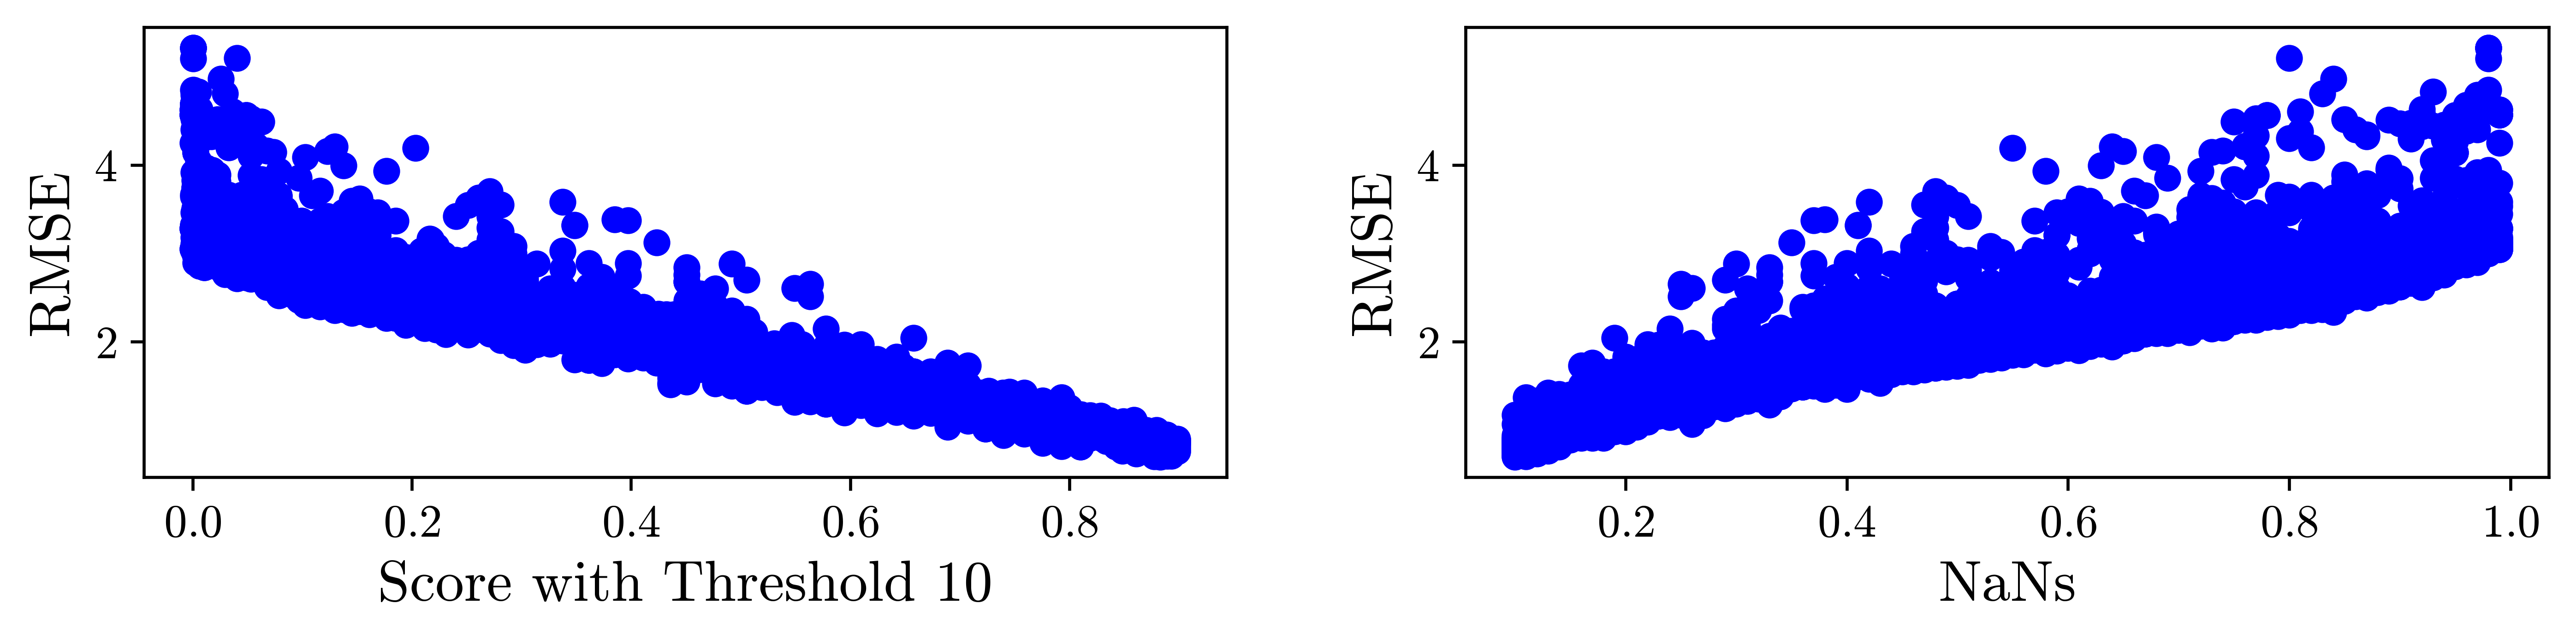

In [17]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df_nan['Score_10'],df_nan['RMSE'],'bo')
plt.xlabel('Score with Threshold 10')
plt.ylabel('RMSE')
plt.subplot(1,2,2)
plt.plot(df_nan['NaN'],df_nan['RMSE'],'bo')
plt.xlabel('NaNs')
plt.ylabel('RMSE')
plt.tight_layout(pad=4)
plt.show()

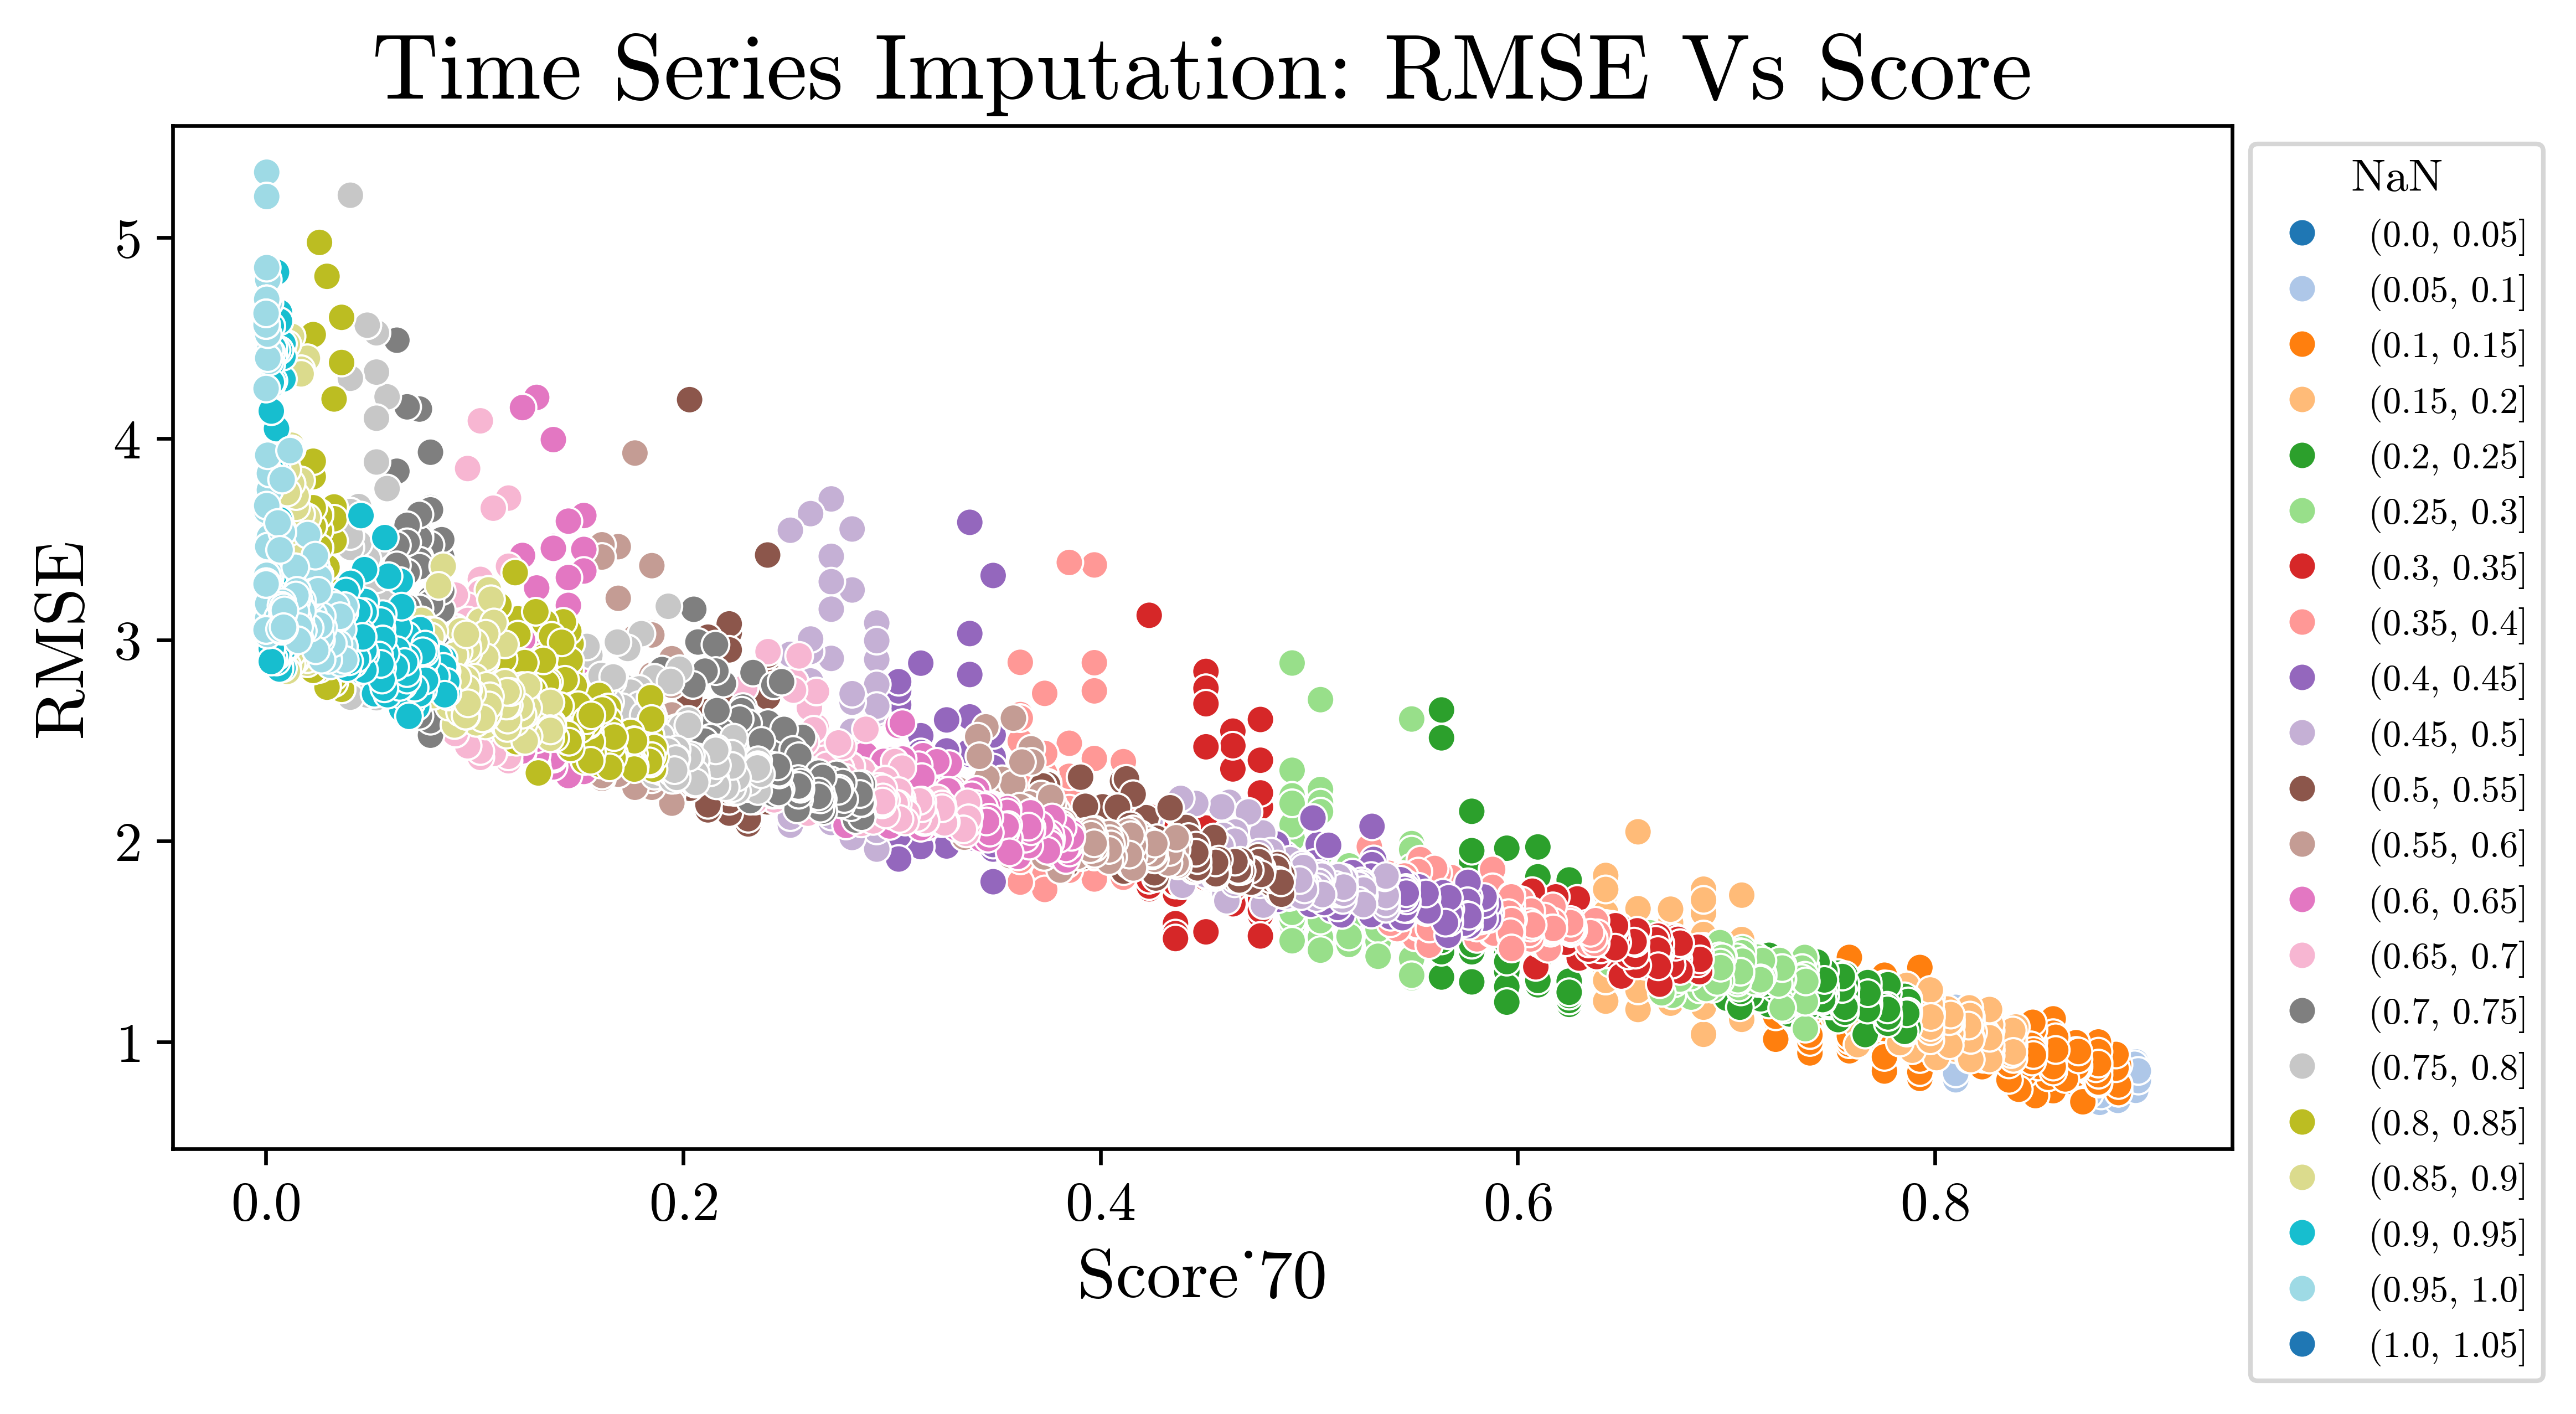

In [18]:
df_nan['bucket'] = pd.cut(df_nan['NaN'], np.arange(0,1.1,0.05))
sns.scatterplot(data=df_nan,x='Score_70',y='RMSE',hue='bucket',palette='tab20')
plt.legend(title='NaN',title_fontsize=10,bbox_to_anchor=(1, 1))
plt.title('Time Series Imputation: RMSE Vs Score')
plt.ylabel('RMSE')
plt.xlabel('Score_70')
plt.show()

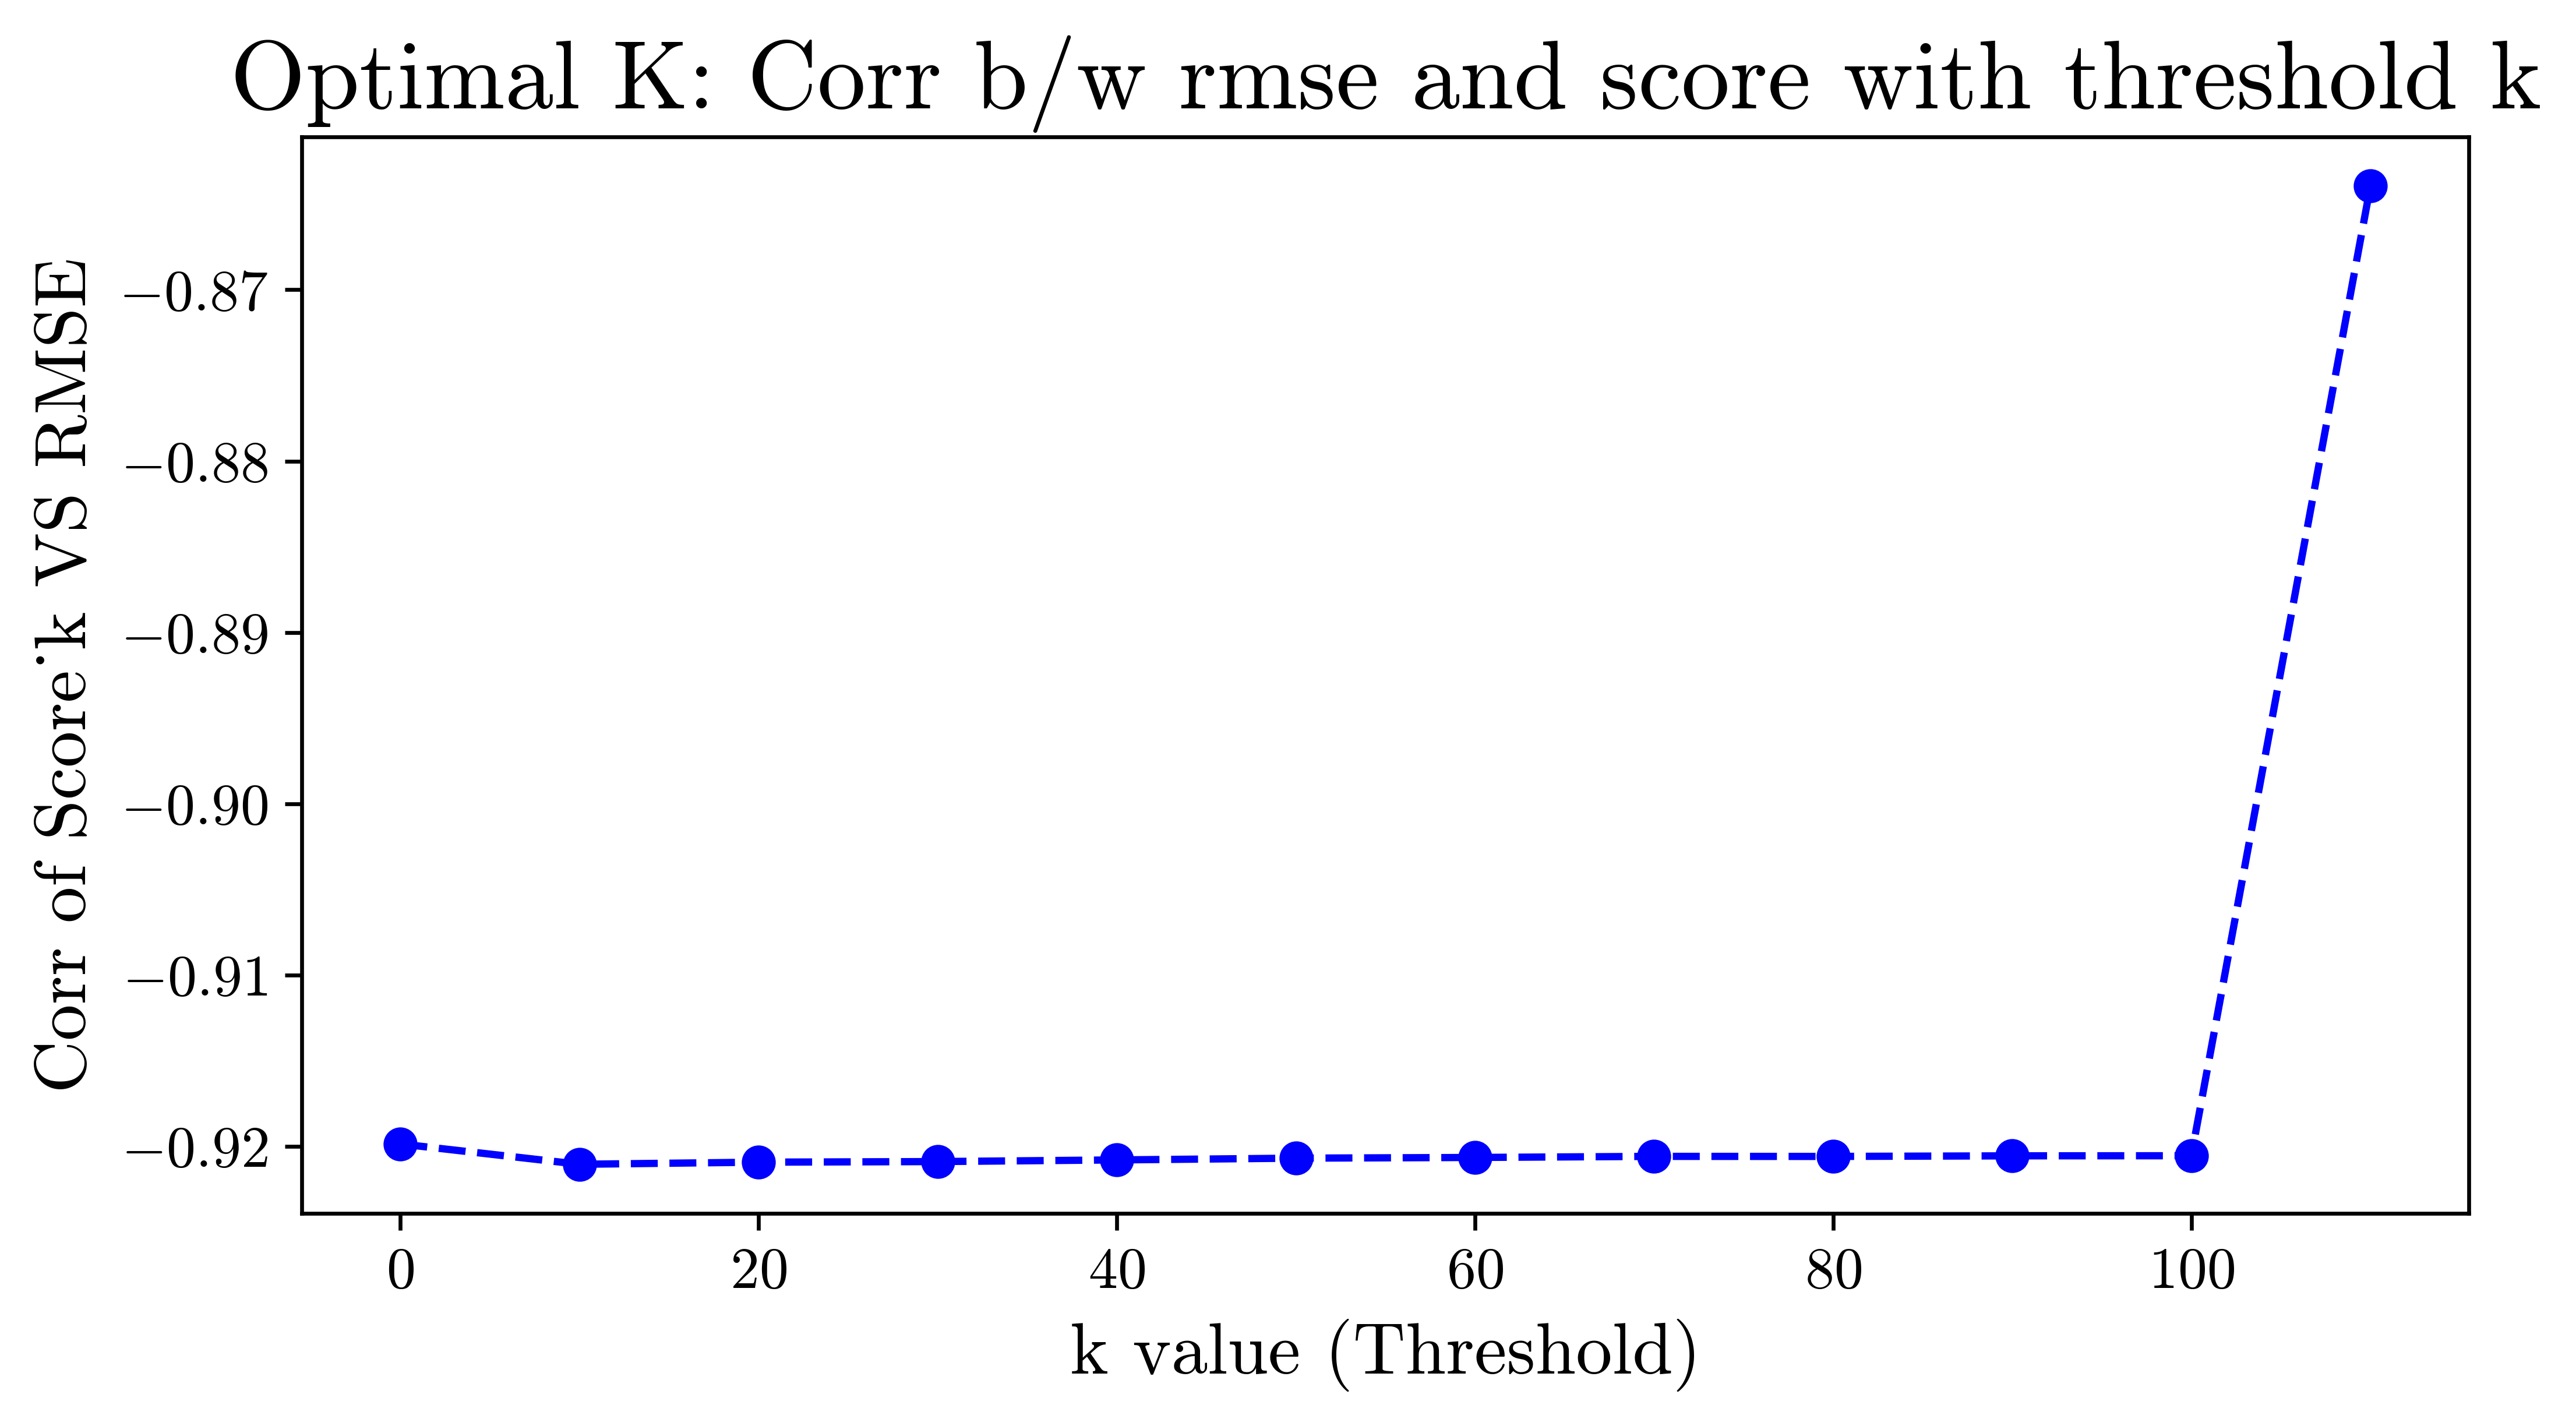

In [19]:
from scipy.stats import pearsonr
k,corr=[],[]
for i in range(0,111,10):
    df_nan['bucket'] = pd.cut(df_nan['Score_'+str(i)], np.arange(0,1.1,0.01))
    df_nan['midpoint'] = df_nan['bucket'].apply(lambda x: x.mid)
    corr.append(pearsonr(df_nan['RMSE'],df_nan['midpoint']).statistic)
    #corr.append(pearsonr(df_nan['RMSE'],df_nan['Score_'+str(i)]).statistic)
    k.append(i)
plt.plot(k,corr,'bo--')
plt.ylabel('Corr of Score_k VS RMSE')
plt.xlabel('k value (Threshold)')
plt.title('Optimal K: Corr b/w rmse and score with threshold k')
plt.show()

## Incremental benefit ??
* For a given NaN Percentage (eg: NaN_percentage = 40%)
* We bucket score Value and see if score inc does RMSE dec??
* If yes then our scoring mechanism is working

**Finally we also plot Mean RMSE vs Score bucket to evaluate if it is monotonic**

In [26]:
df_nan=pd.DataFrame({'NaN':[]}) # Should have NaN% RMSE and Score at various thresholds

for i in np.arange(0,101,10):
    df_nan['Score_'+str(i)]=np.nan

df_nan['RMSE']=np.nan


perc_list=[0.35]
n_loop=1000
pbar=tqdm(total=len(perc_list)*n_loop*3)

for i in perc_list:
    for _ in range(n_loop):
        
        row=[]
        missing_data=create_nans_random(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,101,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)

        
        row=[]
        missing_data=create_nans_continously(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,101,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)

        
        row=[]
        missing_data=create_nans_selectively(data,perc=i)
        imputed_data=knn_interpolate(missing_data)
        row.append(i)
        for k in range(0,101,10):
            row.append(find_score(missing_data,k/100))
        row.append(rmse_data(data,imputed_data))
        df_nan.loc[len(df_nan)]=row
        pbar.update(1)
df_nan.to_excel(f'{"D:/BTP/Results/"}NaNs_Scoring_one_perc.xlsx',index=False)


  0%|          | 0/3000 [00:00<?, ?it/s]

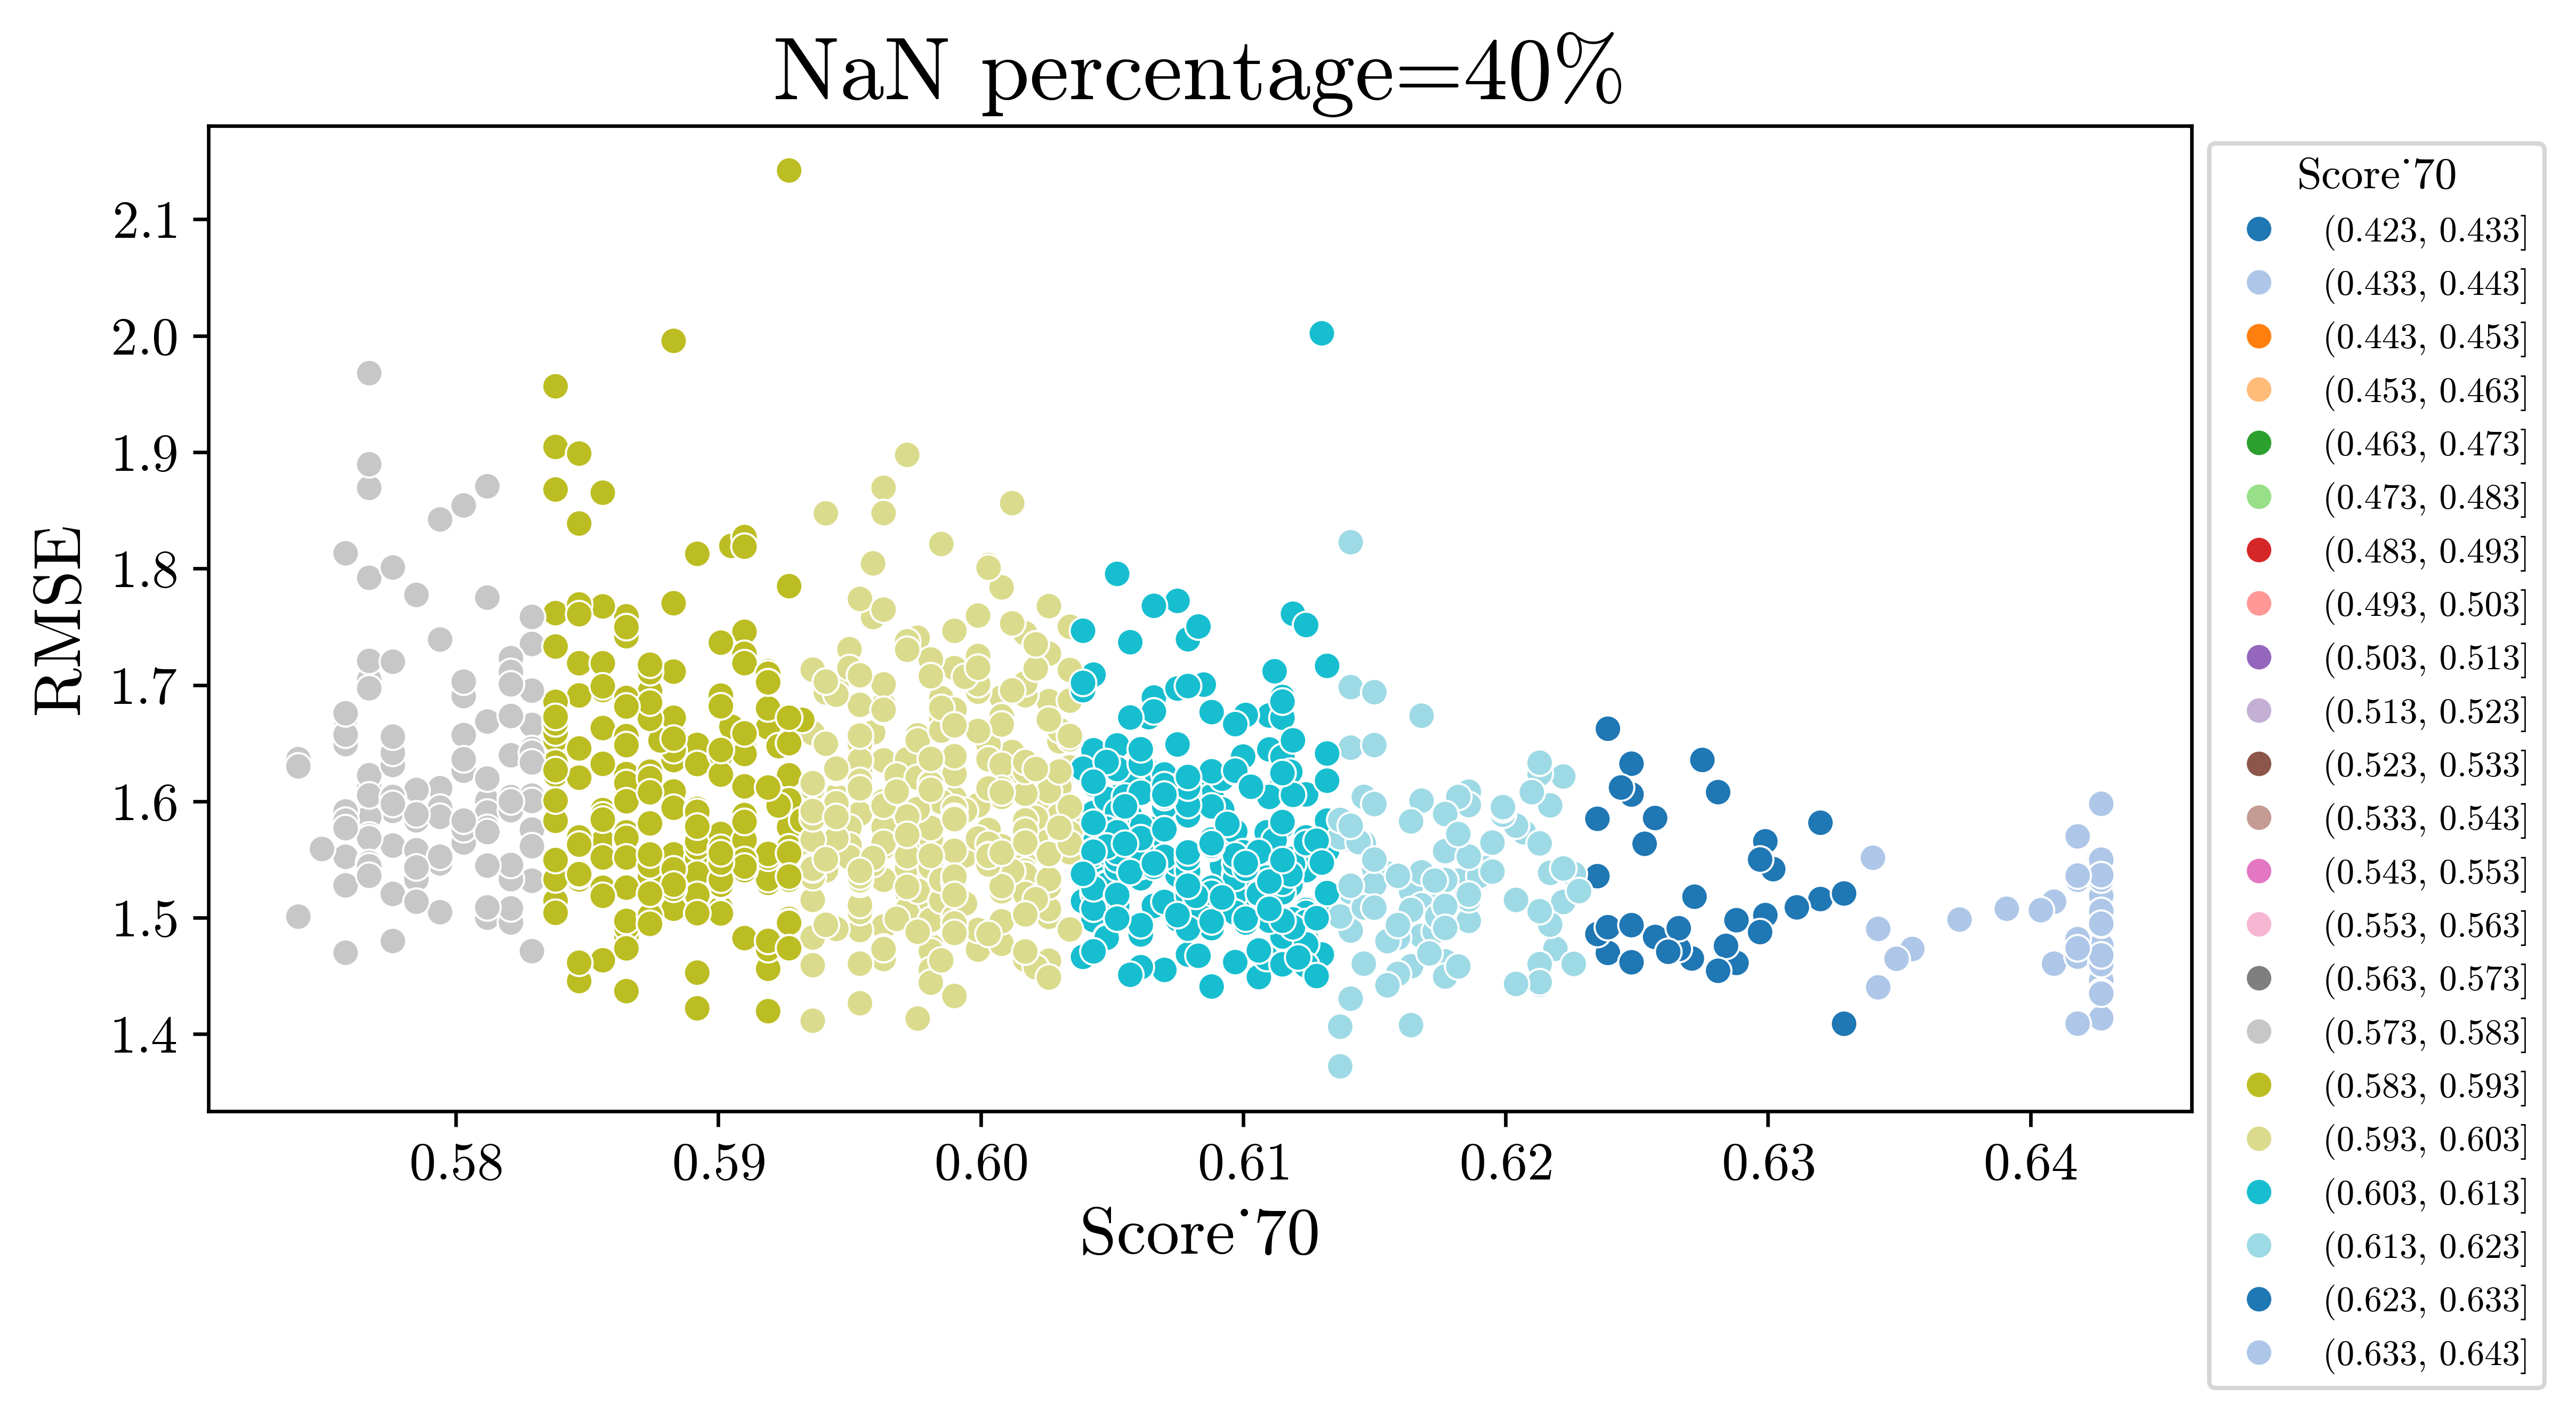

In [27]:
df_nan['bucket'] = pd.cut(df_nan['Score_70'], np.arange(df_nan['Score_70'].min(),df_nan['Score_70'].max(),0.01))
sns.scatterplot(data=df_nan,x='Score_70',y='RMSE',hue='bucket',palette='tab20')
plt.legend(title='Score_70',title_fontsize=10,bbox_to_anchor=(1, 1))
plt.title("NaN percentage=40%")
plt.ylabel('RMSE')
plt.xlabel('Score_70')
plt.show()
plt.show()

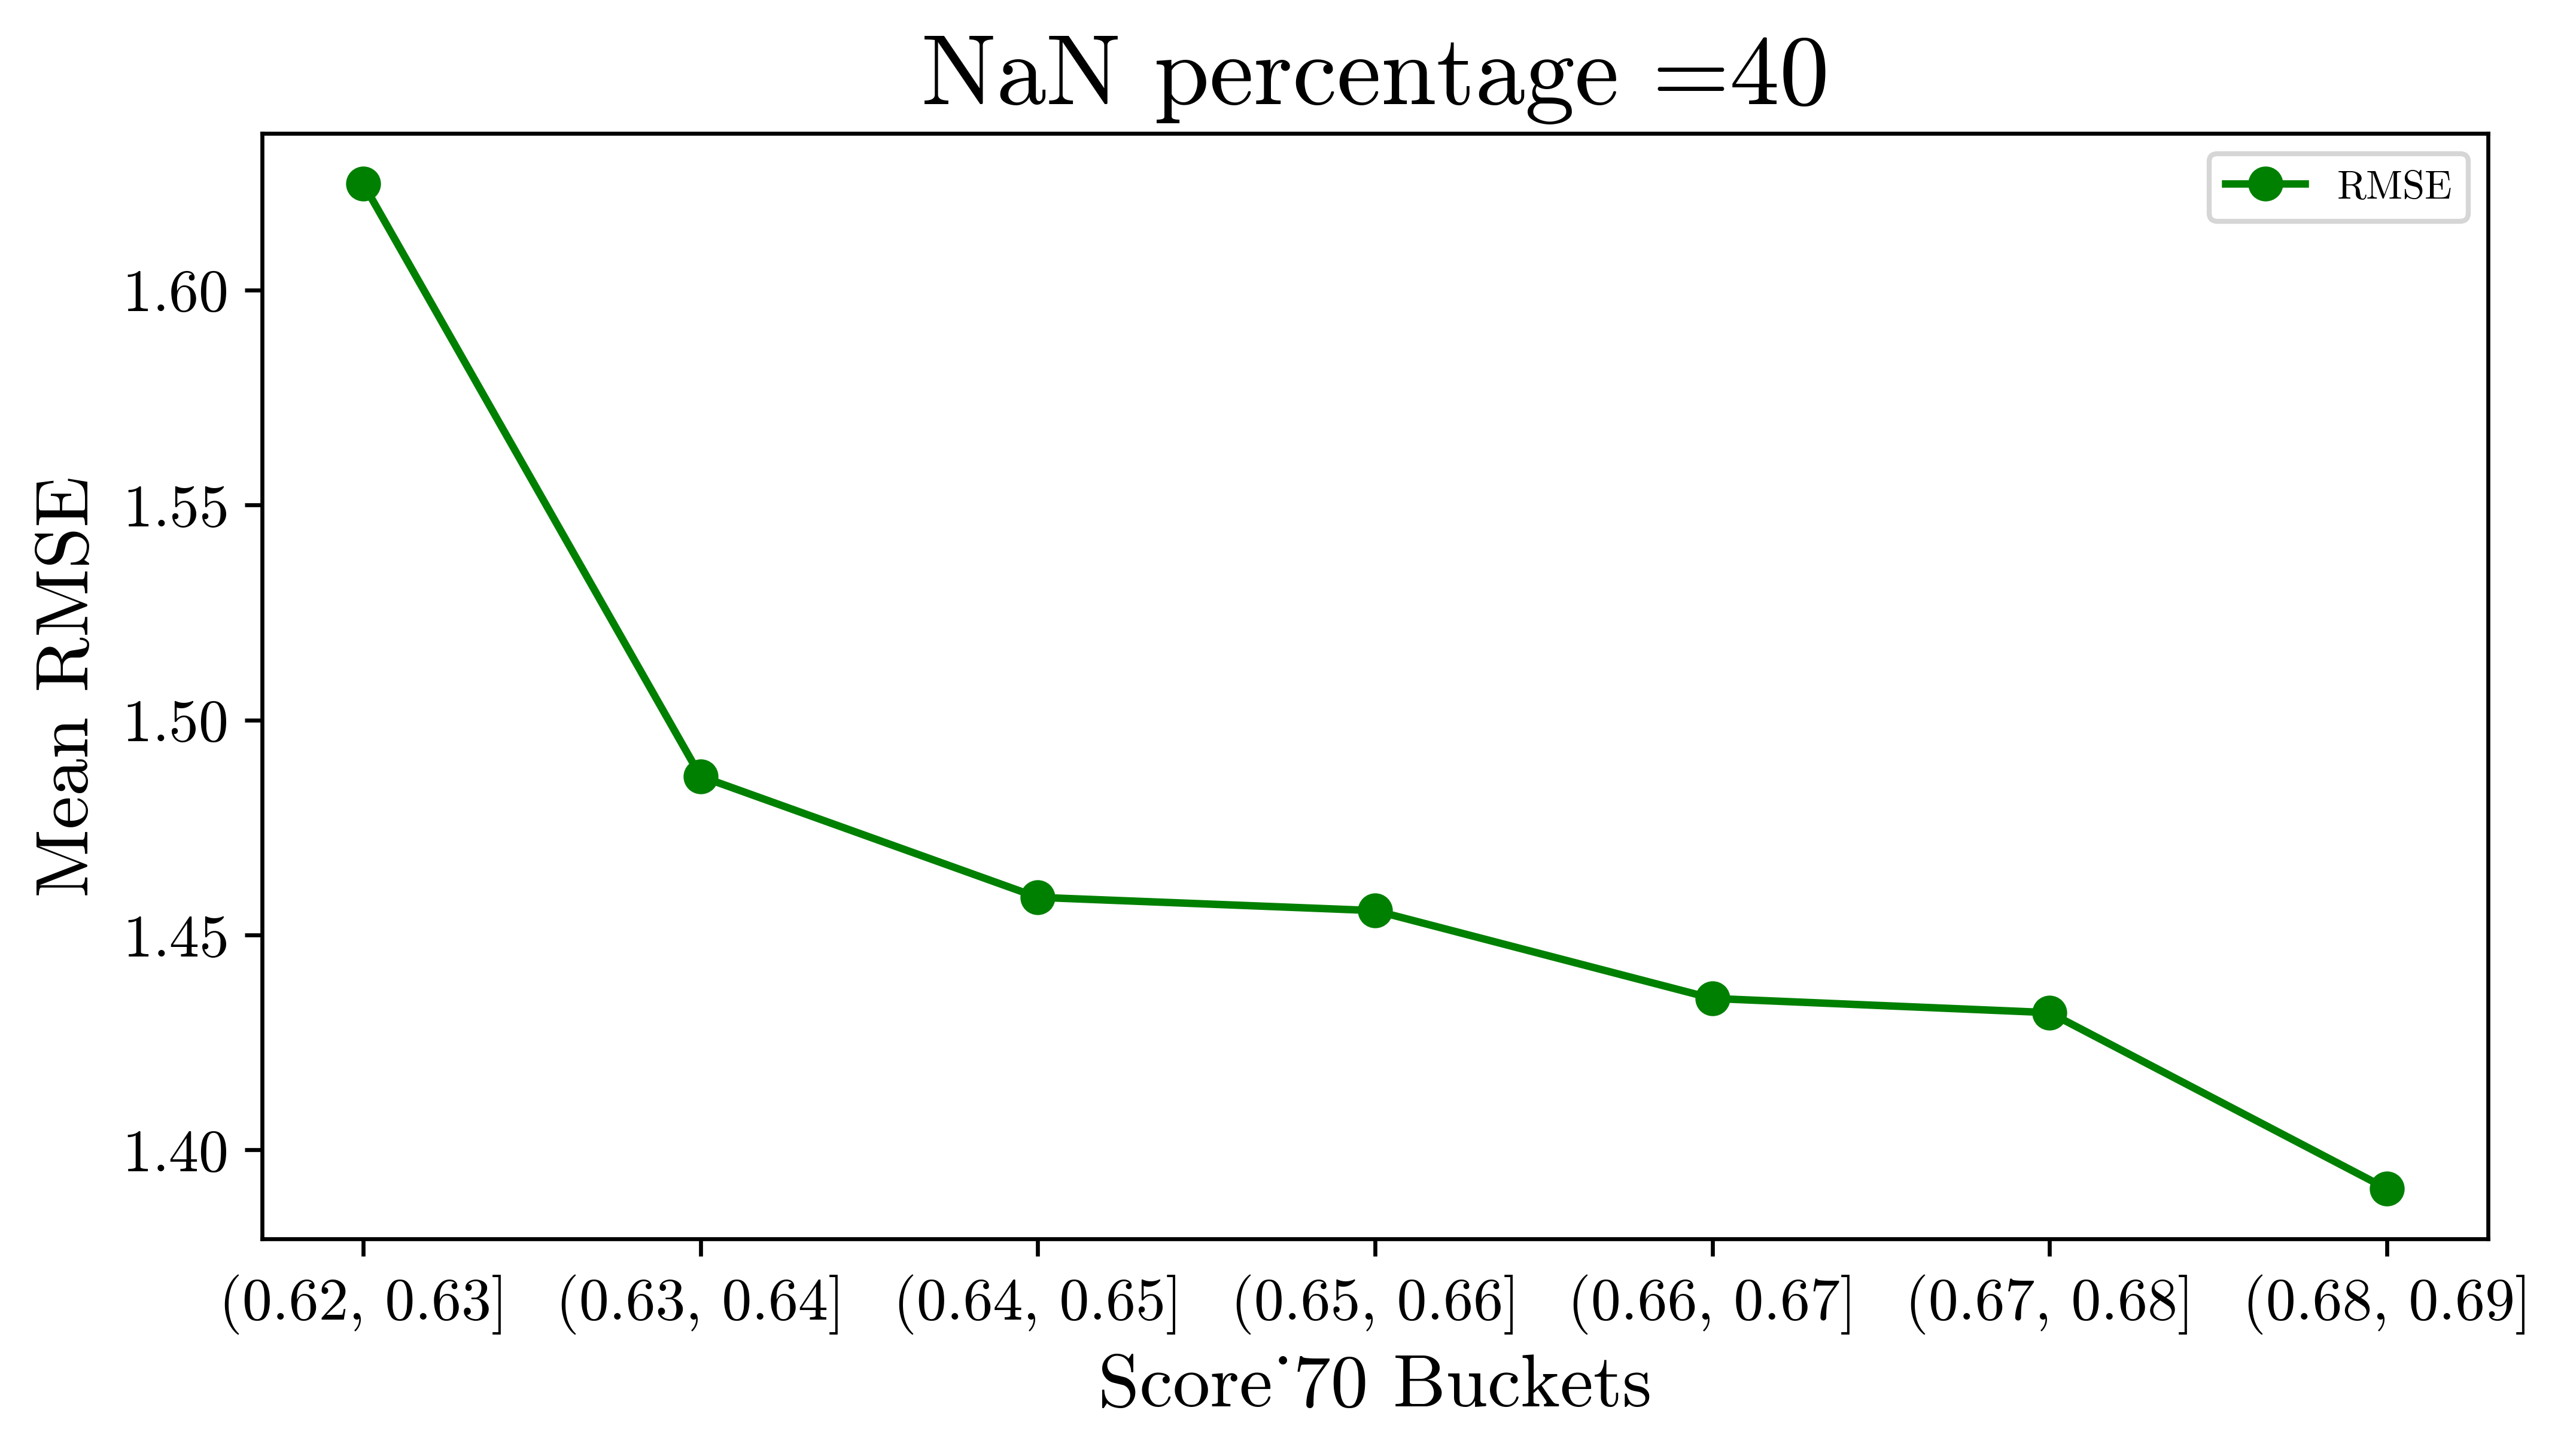

In [25]:
df_nan.groupby('bucket')[['RMSE']].mean().plot(kind='line',marker='o',color='g')
plt.ylabel('Mean RMSE')
plt.xlabel('Score_70 Buckets')
plt.title('NaN percentage =40')
plt.show()